## Demo: Denoising of Multiple Noise Levels Mouse Brain Cortex Images
This notebook demonstrates training an EMDiffuse-n model for a 2D denoising task. Note that training a neural network for actual use should be done with **more training time and more training data** as used here.

## Set the Runtime Type on Google Colab

Set the Runtime type: Go to Runtime -> Change the Runtime type

Runtime type: Python 3 (Python 3 is programming language in which this program is written)

Accelator: GPU (Graphics processing unit (GPU)

## Download and Install EMDiffuse

In [1]:
!git clone https://github.com/Luchixiang/EMDiffuse
%cd EMDiffuse/
!pip install -r requirements.txt

Cloning into 'EMDiffuse'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 741 (delta 42), reused 75 (delta 35), pack-reused 653
Receiving objects: 100% (741/741), 54.76 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (340/340), done.
/home/cxlu/EMDiffuse/example/denoise/EMDiffuse


Note: Before starting, ensure that you're working within the 'EMDiffuse' directory. The directory can be checked with the `!pwd` command and adjusted with the `%cd` command. 

In [ ]:
# %cd ../..

In [2]:
import sys
import os
sys.path.append('RAFT/core')
from RAFT.core.raftConfig import RaftConfig
from RAFT.core.register import registration
import urllib
import zipfile
import glob
from tifffile import imread, imwrite
import matplotlib.pyplot as plt

## Download the Demo Data

We'll be working with a set of example images that show different areas of a mouse's brain cortex. 


The high SNR images (Brain__4w_09.tif) are acquisitions with dwell time 36 µs and the low SNR images were acquired with a dwell time of 0.5 µs (Brain__4w_04.tif), 1 µs (Brain__4w_05.tif), 1.5 µs (Brain__4w_06.tif), 2 µs (Brain__4w_07.tif), 4 µs (Brain__4w_08.tif).

In [4]:
if not os.path.isdir('./dataset'):
    os.mkdir('./dataset')

# Here, we only download the demo training dataset. To download the whole dataset, replace the URL with https://zenodo.org/records/10205819/files/EMDiffuse_dataset.zip?download=1.
zipPath="dataset/EMDiffuse_data_demo.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10720576/files/EMDiffuse_dataset_demo.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("dataset")

Text(0.5, 1.0, 'Ground Truth')

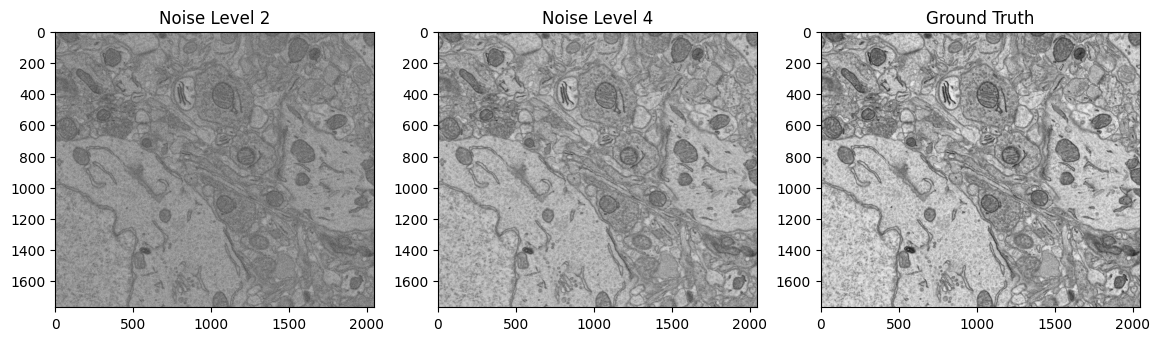

In [3]:
dataset_path = './dataset/EMDiffuse_dataset_demo/brain_train'
subdir = glob.glob(os.path.join(dataset_path, '*'))
example_image_noise1 = imread(os.path.join(subdir[0], 'Brain__4w_05.tif'))
example_image_noise2 = imread(os.path.join(subdir[0], 'Brain__4w_07.tif'))
example_image_gt = imread(os.path.join(subdir[0], 'Brain__4w_09.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(example_image_noise1, cmap='gray')
plt.title('Noise Level 2')
plt.subplot(1,3,2)
plt.imshow(example_image_noise2, cmap='gray')
plt.title('Noise Level 4')
plt.subplot(1,3,3)
plt.imshow(example_image_gt, cmap='gray')
plt.title('Ground Truth')

## Generate Training Data for EMDiffuse-n
Due to the inherent distortion and drift during the EM imaging, each image pair should be registered using optical flow to train the neural network. 

We first need to create a `RaftConfig` object, which defines how to get the pairs of low/high SNR images. 
Key arguments:
 - path: The folder where training images are stored. 
 - patch_size: Since we can't always use the whole image at once, we cut it into smaller ones. As a general rule, use a patch size with a power of two along all axes or at least divisible by 8. For this example, we will use patches of 256x256.
 - overlap: Overlap ratio of adjacent patches. For this example, we will use an overlap ratio of 0.125 (i.e., 32 pixels). 
 - border: The region to be discarded around the edges after alignment, ensuring our training focus remains on the meaningful data.

In [4]:
dataset_path = './dataset/EMDiffuse_dataset_demo/brain_train'
# Set the optical flow registration and crop config
register_config = RaftConfig(path=dataset_path, patch_size=256, border=32, overlap=0.125)
# Start registration and cropping
registration(register_config)

processing image 32, Brain__4w_07.tif


/home/cxlu/anaconda3/envs/EMDiffuse_test/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


processing image 32, Brain__4w_05.tif
processing image 32, Brain__4w_06.tif
processing image 32, Brain__4w_08.tif
processing image 32, Brain__4w_04.tif
processing image 35, Brain__4w_07.tif
processing image 35, Brain__4w_05.tif
processing image 35, Brain__4w_06.tif
processing image 35, Brain__4w_08.tif
processing image 35, Brain__4w_04.tif
processing image 50, Brain__4w_07.tif
processing image 50, Brain__4w_05.tif
processing image 50, Brain__4w_06.tif
processing image 50, Brain__4w_08.tif
processing image 50, Brain__4w_04.tif
processing image 51, Brain__4w_07.tif
processing image 51, Brain__4w_05.tif
processing image 51, Brain__4w_06.tif
processing image 51, Brain__4w_08.tif
processing image 51, Brain__4w_04.tif
processing image 56, Brain__4w_07.tif
processing image 56, Brain__4w_05.tif
processing image 56, Brain__4w_06.tif
processing image 56, Brain__4w_08.tif
processing image 56, Brain__4w_04.tif
processing image 57, Brain__4w_07.tif
processing image 57, Brain__4w_05.tif
processing i

The `registration` function will now register the noisy image with ground truth and generate lots of paired patches that will be used for training the EMDiffuse-n model later. The Cropped patch should be stored at the `denoise` folder within the dataset directory.


## Show Example Patches

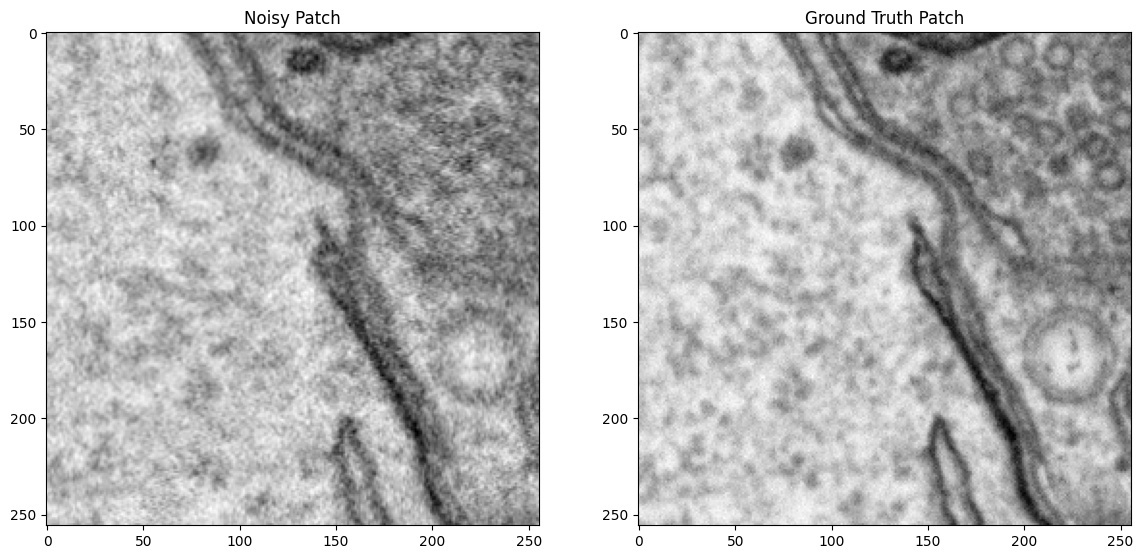

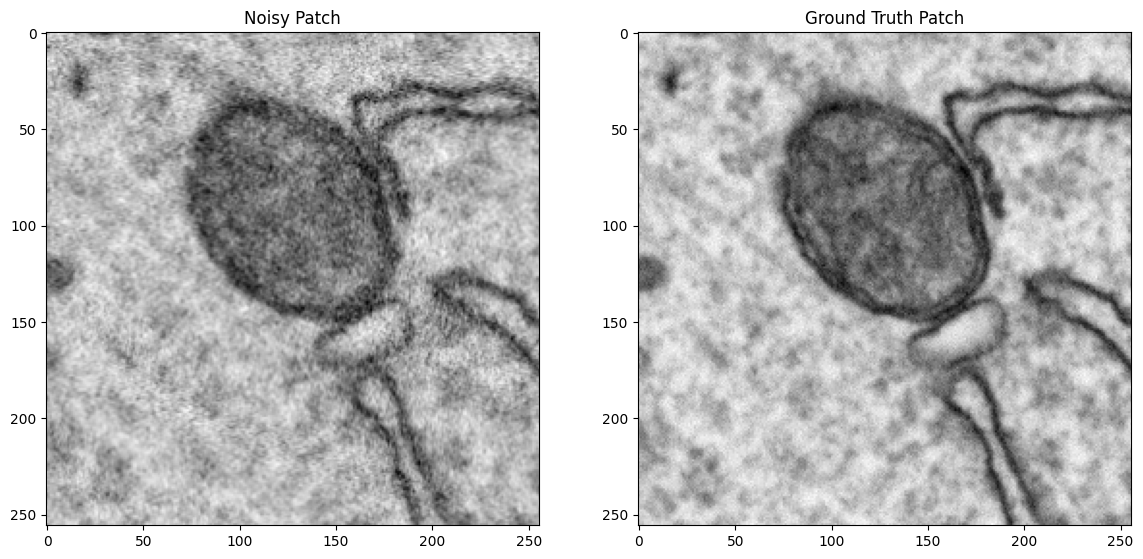

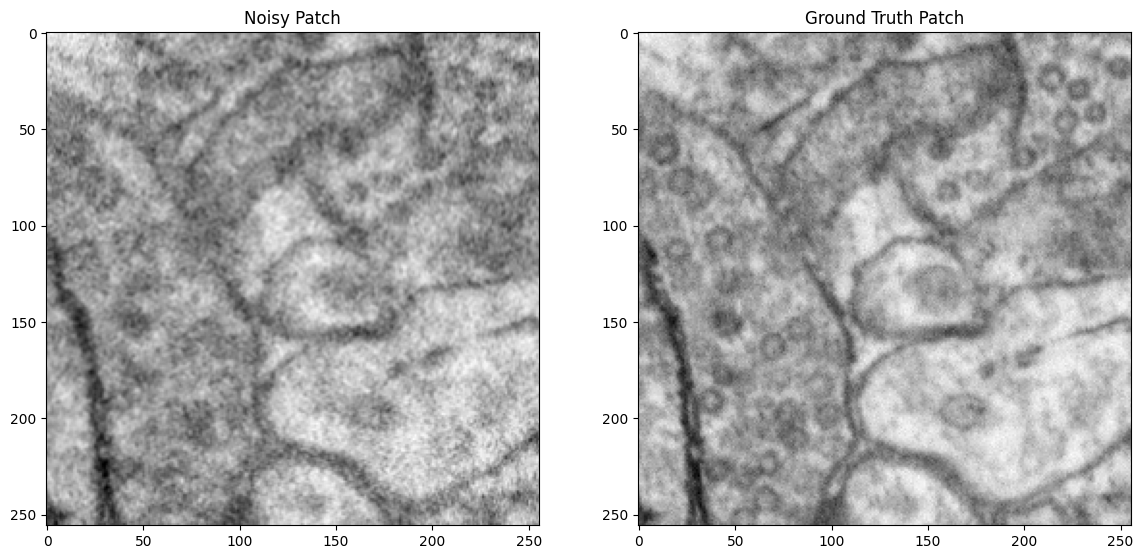

In [7]:
noise_images = glob.glob(os.path.join(dataset_path, 'denoise', 'train_wf', '*', '*', '*.tif'))
if len(noise_images) != 0:
    for i in range(3):
        noisy_img =  imread(noise_images[i])
        gt_img = imread(noise_images[i].replace('train_wf', 'train_gt'))
        plt.figure(figsize=(14,7))
        plt.subplot(1,2,1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title('Noisy Patch')
        plt.subplot(1,2,2)
        plt.imshow(gt_img, cmap='gray')
        plt.title('Ground Truth Patch')

In [3]:
import core.praser as Praser
import os
import warnings
import torch
import torch.multiprocessing as mp

from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
from run import main_worker

## Configuring the EMDiffuse Model and Training
Before we construct the actual EMDiffuse model, we have to define the model and training configurations via an `EMDiffuseConfig` object, which includes：
- path: The location of the training patches that have been aligned and cropped.
- lr: The learning rate.
- config: Some basic parameters of the model and the dataset, including the network architecture, loss function, and noise scheduler of diffusion. Please see the JSON files for more details.
- batch_size: Training batch size on every gpu. 
- phase: The mode of operation, either train or test.



In [4]:
config = EMDiffuseConfig(config='config/EMDiffuse-n.json', phase='train', 
                         path='./dataset/EMDiffuse_dataset_demo/brain_train/denoise/train_wf', batch_size=4, lr=5e-5)
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
model = create_EMDiffuse(opt)
print(f'length of training data loader: {len(model.phase_loader)}, length of validation dataloader: {len(model.val_loader)}')

results and model will be saved in experiments/train_EMDiffuse-n_240220_184213
length of training data loader: 144, length of validation dataloader: 26


## Training
Training the model will likely take some time. Both the model's state and its training metrics are automatically saved within a newly created directory, `./experiments/train_EMDiffuse-n_time`, as logged above. Here, `time` is a placeholder for the actual timestamp when the training session begins, ensuring each training session is uniquely identifiable.


Furthermore, you can look at the predictions for some of the validation images, which can help recognize problems early on. 

In [ ]:
model.train()

epoch 1: training start
epoch 2: training start
